In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

# Functions

In [2]:
def clean(df):
    '''
    This Function filters out the df by the city of Los Angeles, drops columns,
    renames, sets the index to the date, & converts to Fahrenheit
    
    '''
    
    # Filtering out by USA
    df = df[df.Country == "United States"]
    
    # Filtering out by Los Angeles
    df = df[df.City == "Los Angeles"]
    
    # Dropping columns that wont be needed
    df = df.drop(columns=['Country', 'Latitude', 'Longitude', 'City', 'AverageTemperatureUncertainty'])
    
    # Renaming AverageTemperature to just temp
    df = df.rename(columns={"AverageTemperature": "temp"})
    
    # Converting sale_date type object to datetime64
    df.dt = pd.to_datetime(df.dt)
    
    # Removing dates before 2010-09-01, leaving me excatly 3 years
    df = df[~(df['dt'] < '2009-09-01')]
    
    # Resetting the index to datetime
    df = df.set_index('dt').sort_index()
    
    # Convert to fahrenheit
    df.temp = df.temp.apply(celsius_to_fahrenheit)
    
    return df

In [3]:
def celsius_to_fahrenheit(c):
    c = float(c)
    c = (c*(9/5)) + 32
    return c

In [4]:
def split(df):
    '''
    Splits the data into train, validate, and split. Then resampling by Month
    '''
    # Train 09/2009 - 12/2011
    train = df['2009-09-01':'2011-12-01']
    
    # Validate 12/2011 - 12/2012
    validate = df['2012-01-01':'2012-12-01']
    
    # Test 12/2012 - 09/2013
    test = df['2013-01-01':'2013-09-01']
    
        
    # Resampling it so it has a Frequency = "M"
    train = train.resample('M').mean()
    validate = validate.resample('M').mean()
    test = test.resample('M').mean()
    
    return train, validate, test

In [35]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(f'--RMSE: {target_var}')
    plt.show()

In [36]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is goign to take in the model type as a string, the target variable as a string,
    and run the evalute() function to compute the rsme,
    and append to the data frame a row with the model_type, target_var and rmse.
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

In [37]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    Creating a function to grab rmse
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [38]:
def plot_samples(target_var):
    '''
    this function wil plot the train, validate and test values for a single varibable across all dates
    '''
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)

### Plotting Defaults

In [5]:
plt.rc('figure', figsize=(9, 4))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Acquire

In [6]:
# Importing saas.csv to a Data Frame
df = pd.read_csv('temp_city.csv')

In [7]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


# Prepare

### Clean

In [9]:
df = clean(df)

### Split

In [10]:
train, validate, test = split(df)

### Plot the Split

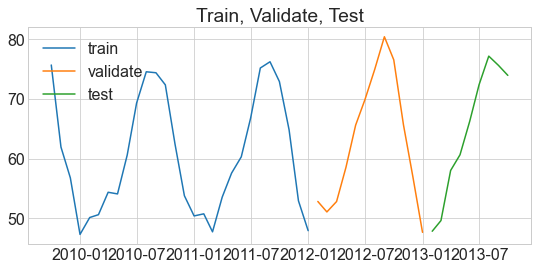

In [11]:
plt.plot(train.index, train.temp, label='train')
plt.plot(validate.index, validate.temp, label='validate')
plt.plot(test.index, test.temp, label='test')
plt.xticks(rotation=0)
plt.title(label='Train, Validate, Test')
plt.legend()
plt.show()

### Shape

In [12]:
train.shape

(28, 1)

In [13]:
validate.shape

(12, 1)

In [14]:
test.shape

(9, 1)

# Explore

### Graphing

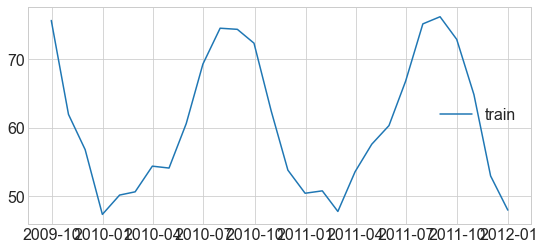

In [15]:
# Taking a look at my train
plt.plot(train.index, train.temp, label='train')
plt.legend()
plt.show()

### Questions

    What is the Average temp?

In [16]:
train.temp.mean()

60.564842857142864

#### `60.56 Degrees Fahrenheit`

    What is Coldest Month?

In [17]:
train.loc[train.temp.idxmin()]

temp    47.3342
Name: 2009-12-31 00:00:00, dtype: float64

#### `December @ 47.33 Degrees`

    What is the Hottest Month?

In [18]:
train.loc[train.temp.idxmax()]

temp    76.2206
Name: 2011-08-31 00:00:00, dtype: float64

#### `August @ 76.22 Degrees`

In [19]:
explore = train.reset_index()

In [20]:
explore.dt = pd.to_datetime(explore.dt)

In [21]:
explore["month"]= explore.dt.dt.month

In [22]:
explore["year"]= explore.dt.dt.year

In [23]:
explore.groupby('year').temp.mean()

year
2009    60.4400
2010    60.5966
2011    60.5747
Name: temp, dtype: float64

In [24]:
explore.groupby('year').temp.min()

year
2009    47.3342
2010    50.1620
2011    47.7662
Name: temp, dtype: float64

In [25]:
explore.groupby('year').temp.max()

year
2009    75.6770
2010    74.5448
2011    76.2206
Name: temp, dtype: float64

### Hottest Months by Year

In [26]:
# Using idxmax to return loc of the hottest month in 2009
explore.loc[explore[explore.year == 2009].temp.idxmax()]

dt       2009-09-30 00:00:00
temp                  75.677
month                      9
year                    2009
Name: 0, dtype: object

In [27]:
# Using idxmax to return loc of the hottest month in 2010
explore.loc[explore[explore.year == 2010].temp.idxmax()]

dt       2010-07-31 00:00:00
temp                 74.5448
month                      7
year                    2010
Name: 10, dtype: object

In [28]:
# Using idxmax to return loc of the hottest month in 2011
explore.loc[explore[explore.year == 2011].temp.idxmax()]

dt       2011-08-31 00:00:00
temp                 76.2206
month                      8
year                    2011
Name: 23, dtype: object

### Coldest Months by Year

In [29]:
# Using idxmax to return loc of the hottest month in 2009
explore.loc[explore[explore.year == 2009].temp.idxmin()]

dt       2009-12-31 00:00:00
temp                 47.3342
month                     12
year                    2009
Name: 3, dtype: object

In [30]:
# Using idxmax to return loc of the hottest month in 2010
explore.loc[explore[explore.year == 2010].temp.idxmin()]

dt       2010-01-31 00:00:00
temp                  50.162
month                      1
year                    2010
Name: 4, dtype: object

In [31]:
# Using idxmax to return loc of the hottest month in 2011
explore.loc[explore[explore.year == 2011].temp.idxmin()]

dt       2011-02-28 00:00:00
temp                 47.7662
month                      2
year                    2011
Name: 17, dtype: object

### Explore Takeaways

- Coldest Months Range from Dec-Feb year by year
- Hottes Months Range from July-Sep by year to to year
- Coldest Month year 2009-2011 was December
- Hottest Month year 2009-2011 was August
- Graph seems to have a regular looking cycle

# Modeling

### Target 

In [50]:
target_var='temp'

### Evaluation DataFrame

In [64]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

### Baseline 

Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

In [51]:
train_mean = round(train[target_var].mean(), 2)
train_mean

60.56

In [52]:
yhat_df = pd.DataFrame({target_var: [train_mean]}, index = validate.index)

In [53]:
yhat_df.head()

,temp
dt,
2012-01-31,60.56
2012-02-29,60.56
2012-03-31,60.56
2012-04-30,60.56
2012-05-31,60.56


### Baseline RMSE

In [54]:
rmse = evaluate(target_var)

### eval_df

In [66]:
eval_df = append_eval_df(model_type = 'baseline/simple avg', target_var = target_var)
eval_df

,model_type,target_var,rmse
0,baseline/simple avg,temp,11.0
1,baseline/simple avg,temp,11.0


### Plotting Baseline

--RMSE = 11.0


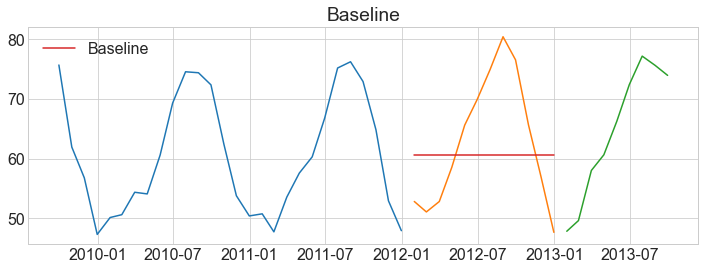

In [63]:
plot_samples(target_var)
plt.plot(yhat_df[target_var], label='Baseline')
plt.title("Baseline")
rmse = evaluate(target_var)
print(f'--RMSE = {rmse}')
plt.legend()
plt.show()